## 使用PyTorch对同文件夹下wgan_gp进行复现

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('C:/Users/Raphael/OneDrive/备份/桌面/大学生活和学习/教材/深度学习/Generative-Deep-Learning')
from utiles import display
device =  torch.device('cuda')


In [5]:
CRITIC_STEPS = 3
GP_WEIGHT = 10.0

### 加载数据库

In [6]:
device =  torch.device('cuda')

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255.0 - 127.5) / 127.5)
])
train_data = datasets.ImageFolder(root = "C:/Users/Raphael/OneDrive/备份/桌面/大学生活和学习/教材/深度学习/Generative-Deep-Learning/datas",transform=transform)
train_loader = DataLoader(train_data,batch_size=64,shuffle=True)


展示一些数据

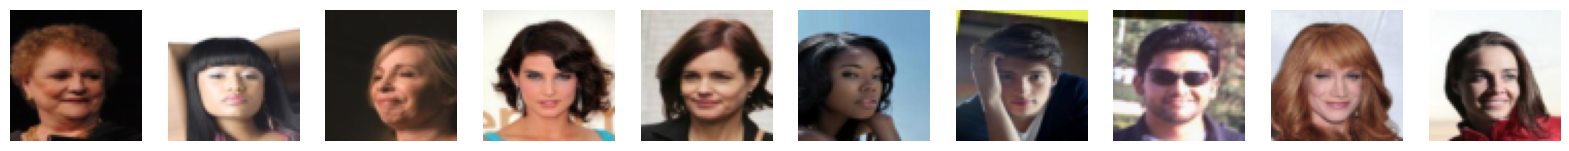

In [7]:
# Plot some training images
real_batch = next(iter(train_loader))

# Convert the batch to numpy array
real_batch_images = real_batch[0]

real_batch_images = np.transpose(torch.squeeze(real_batch_images).numpy(),(0,2,3,1))

# Display the images
display(real_batch_images, cmap="gray_r", as_type="float32")

### 定义评价器和生成器

In [8]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic,self).__init__()
        self.conv1 = nn.Conv2d(1,64,kernel_size=4,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(128,momentum=0.9)
        self.conv3 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(256,momentum=0.9)
        self.conv4 = nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(512,momentum=0.9)
        self.conv5 = nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False)

    def forward(self,x):
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.dropout(x,0.3)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.conv5(x))
        return x.flatten()

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.convt1 = nn.ConvTranspose2d(100,512,kernel_size=4,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(512,momentum=0.9)
        self.convt2 = nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(256,momentum=0.9)
        self.convt3 = nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(128,momentum=0.9)
        self.convt4 = nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(64,momentum=0.9)
        self.convt5 = nn.ConvTranspose2d(64,1,kernel_size=4,stride=2,padding=1,bias=False)
    
    def forward(self,x):
        x = x.view(-1,100,1,1)
        x = F.relu(self.bn1(self.convt1(x)))
        x = F.relu(self.bn2(self.convt2(x)))
        x = F.relu(self.bn3(self.convt3(x)))
        x = F.relu(self.bn4(self.convt4(x)))
        x = torch.tanh(self.convt5(x))
        return x


### 定义梯度惩罚函数和WGAN类

In [10]:
class WGAN(nn.Module):
    def __init__(self, critic, generator, latent_dim):
        super(WGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim

        self.c_optimizer = torch.optim.Adam(self.critic.parameters())
        self.g_optimizer = torch.optim.Adam(self.generator.parameters())

    def forward(self, real_images):
        batch_size = real_images.shape[0]
        random_latent_vectors = torch.randn((1,batch_size, self.latent_dim)).cuda()

        generated_images = self.generator(random_latent_vectors)
        real_predictions = self.critic(real_images)
        fake_predictions = self.critic(generated_images)

        return real_predictions, fake_predictions, generated_images
    
    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = torch.rand((batch_size,1,1,1)).cuda()
        diff = fake_images-real_images
        interpolated = real_images + alpha*diff

        interpolated.requires_grad_(True) # 保留梯度信息
        pred = self.critic(interpolated)  
        # torch.autograd.grad函数被用于计算pred（评价者对插值的预测）相对于interpolated（真实图像和生成图像之间的插值）的梯度。
        grads = torch.autograd.grad(
            outputs=pred,
            inputs=interpolated,
            grad_outputs=torch.ones_like(pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        norm = grads.view(grads.size(0),-1).norm(2,dim = 1)
        gp = ((norm-1.0) ** 2).mean()
        return gp



### 定义训练函数

In [11]:
def train(wgan, data_loader, c_optimizer, g_optimizer, epochs):
    # 创建一个列表来保存生成的图像
    generated_images = []

    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(data_loader):
            real_images = real_images.cuda()
            batch_size = real_images.shape[0]

            for i in range(CRITIC_STEPS):
                real_predictions,fake_predictions,fake_images = wgan(real_images)

                c_wass_loss = fake_predictions.mean() - real_predictions.mean()
                c_gp = wgan.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * GP_WEIGHT

                c_optimizer.zero_grad()
                c_loss.backward()
                c_optimizer.step()

            real_predictions,fake_predictions,fake_images = wgan(real_images)
            g_loss = -fake_predictions.mean()


            g_optimizer.zero_grad()          
            g_loss.backward()
            g_optimizer.step()

            if i % 5 == 0:
                print(f"Epoch {epoch}, Batch {i}, D loss: {c_loss.item()}, G loss: {g_loss.item()}")

        # 每5个epoch生成并保存10张图像
        if epoch % 5 == 0:
            with torch.no_grad():
                fake_images = wgan.generator(torch.randn(10, 100).cuda())
                generated_images.append(fake_images)

    # 训练结束后显示生成的图像
    for i, images in enumerate(generated_images):
        plt.figure(figsize=(10,10))
        for j, image in enumerate(images):
            plt.subplot(10, 10, j+1)
            plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0)* 127.5 + 127.5)
            plt.axis('off')
        plt.show()


### 开始训练

In [12]:

# Create the critic and generator
critic = Critic()
generator = Generator()

# Move models to GPU
critic.cuda()
generator.cuda()

# Create the WGAN

wgan = WGAN(critic, generator, 100).cuda()
c_optimizer = optim.Adam(wgan.critic.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(wgan.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

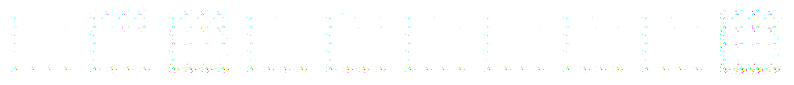

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

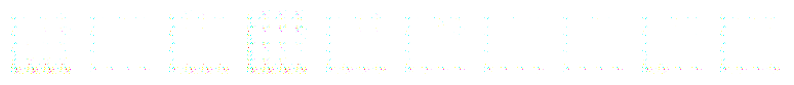

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

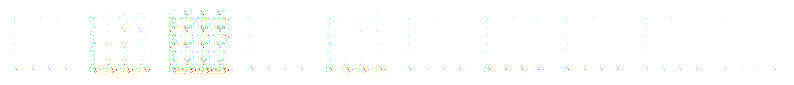

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

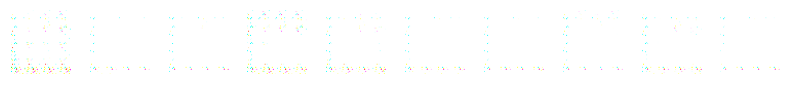

In [13]:
train(wgan, train_loader, c_optimizer, g_optimizer,  20)

### 测试

TypeError: Invalid shape (3, 64, 64) for image data

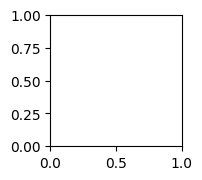

In [14]:
with torch.no_grad():
    # 创建一个随机潜在向量
    latent_vector = torch.randn(64, 100).to(device)
    # 使用生成器生成图像
    generated_images = wgan.generator(latent_vector)
    # 将生成的图像从[-1, 1]的范围转换到[0, 1]的范围
    generated_images = (generated_images + 1) / 2
    # 将生成的图像从GPU移动到CPU，并转换为numpy数组
    generated_images = torch.squeeze(generated_images).cpu().numpy()
    # 显示生成的图像
    display(generated_images)